In [1]:
# data = pd.read_csv("bbca_data.csv")

In [2]:
# data = data.drop(index=[0, 1])
# data.rename(columns={'Price': 'Date'}, inplace=True)


In [3]:
# data.to_csv("bbca.csv")


In [4]:
# ===== Cell 1: setup =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# file paths (ubah kalau beda)
PRICE_PATH = "bbca.csv"  # <— file harga baru kamu
FUND_PATH  = "bbca_fundamentals_quarterly_2021_2023.csv"

pd.set_option("display.max_columns", 200)

In [5]:
# ===== Cell 2: load & clean price =====
def load_price(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # drop kolom index kalau ada
    for junk in ["Unnamed: 0", "Unnamed: 1"]:
        if junk in df.columns:
            df = df.drop(columns=[junk])

    assert "Date" in df.columns, "Kolom 'Date' wajib ada."
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    # pastikan numeric
    for c in ["Close","High","Low","Open","Volume"]:
        if c in df.columns and df[c].dtype == object:
            df[c] = df[c].astype(str).str.replace(",", "", regex=False)
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["Date"]).sort_values("Date")
    # deduplicate per tanggal (ambil baris terakhir)
    df = df.groupby("Date", as_index=False).last()
    return df

price = load_price(PRICE_PATH)
price.head(5)

,Date,Close,High,Low,Open,Volume
0,2020-09-01,5771.082031,5771.082031,5523.244153,5558.649564,67446000
1,2020-09-02,5695.846191,5806.488114,5633.886715,5771.082699,66065000
2,2020-09-03,5753.378906,5753.378906,5576.351863,5722.399174,68208500
3,2020-09-04,5647.163086,5709.122556,5545.372529,5709.122556,80613500
4,2020-09-07,5563.075195,5629.460341,5487.838697,5607.331959,64249500


In [6]:
# ===== Cell 3: technical indicators =====
def add_technicals(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # SMA/EMA
    out["SMA_20"] = out["Close"].rolling(window=20, min_periods=20).mean()
    out["EMA_20"] = out["Close"].ewm(span=20, adjust=False).mean()

    # Bollinger (20, 2)
    bb_w, bb_std = 20, 2.0
    roll_mean = out["Close"].rolling(bb_w, min_periods=bb_w).mean()
    roll_std  = out["Close"].rolling(bb_w, min_periods=bb_w).std()
    out["Bollinger_upper"] = roll_mean + bb_std * roll_std
    out["Bollinger_lower"] = roll_mean - bb_std * roll_std
    out["BB_percentB"]  = (out["Close"] - out["Bollinger_lower"]) / (out["Bollinger_upper"] - out["Bollinger_lower"])
    out["BB_bandwidth"] = (out["Bollinger_upper"] - out["Bollinger_lower"]) / (roll_mean + 1e-12)

    # RSI(14)
    def rsi(series, window=14):
        delta = series.diff()
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        roll_up = up.ewm(alpha=1/window, adjust=False).mean()
        roll_down = down.ewm(alpha=1/window, adjust=False).mean()
        rs = roll_up / (roll_down + 1e-12)
        return 100 - (100 / (1 + rs))
    out["RSI_14"] = rsi(out["Close"], window=14)

    # MACD (12, 26, 9)
    fast, slow, signal = 12, 26, 9
    ema_fast = out["Close"].ewm(span=fast, adjust=False).mean()
    ema_slow = out["Close"].ewm(span=slow, adjust=False).mean()
    out["MACD_line"]   = ema_fast - ema_slow
    out["MACD_signal"] = out["MACD_line"].ewm(span=signal, adjust=False).mean()
    out["MACD_hist"]   = out["MACD_line"] - out["MACD_signal"]

    # log-return & volatilitas cepat
    out["ret_log"] = np.log(out["Close"] / out["Close"].shift(1))
    out["roll_std_5"]  = out["ret_log"].rolling(5,  min_periods=5).std()
    out["roll_std_10"] = out["ret_log"].rolling(10, min_periods=10).std()

    # kalender (cyclical)
    out["dayofweek"] = out["Date"].dt.dayofweek
    out["month"]     = out["Date"].dt.month
    out["day_sin"]   = np.sin(2*np.pi*out["dayofweek"]/7)
    out["day_cos"]   = np.cos(2*np.pi*out["dayofweek"]/7)
    out["mon_sin"]   = np.sin(2*np.pi*(out["month"]-1)/12)
    out["mon_cos"]   = np.cos(2*np.pi*(out["month"]-1)/12)

    return out

price = add_technicals(price)
price.tail(3)

,Date,Close,High,Low,Open,Volume,SMA_20,EMA_20,Bollinger_upper,Bollinger_lower,BB_percentB,BB_bandwidth,RSI_14,MACD_line,MACD_signal,MACD_hist,ret_log,roll_std_5,roll_std_10,dayofweek,month,day_sin,day_cos,mon_sin,mon_cos
1182,2025-08-01,8300.0,8425.0,8300.0,8400.0,86196100,8473.75,8480.919810,8665.332743,8282.167257,0.046541,0.045218,35.435426,-110.212394,-106.541866,-3.670528,0.003017,0.008261,0.007310,4,8,-0.433884,-0.900969,-0.5,-0.866025
1183,2025-08-04,8275.0,8350.0,8275.0,8325.0,49054500,8456.25,8461.308399,8653.517518,8258.982482,0.040598,0.046656,34.361531,-113.286477,-107.890788,-5.395689,-0.003017,0.006471,0.007148,0,8,0.000000,1.000000,-0.5,-0.866025
1184,2025-08-05,8425.0,8450.0,8325.0,8350.0,69475900,8452.50,8457.850457,8649.116110,8255.883890,0.430067,0.046523,45.110140,-102.438121,-106.800255,4.362133,0.017965,0.011094,0.009371,1,8,0.781831,0.623490,-0.5,-0.866025


In [7]:
# ===== Cell 3b (ADD): lag & momentum features =====
def add_lags_and_momentum(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # set lag yang umum untuk daily
    lag_list = [1, 2, 3, 5, 10, 20]

    # kolom yang dilag
    base_cols = [
        "ret_log", "Close", "Volume",
        "RSI_14", "MACD_line", "MACD_signal",
        "BB_percentB", "BB_bandwidth",
        "roll_std_5", "roll_std_10",
        "SMA_20", "EMA_20"
    ]
    for c in base_cols:
        if c in out.columns:
            for L in lag_list:
                out[f"{c}_lag{L}"] = out[c].shift(L)

    # momentum / smoothing return
    for w in [5, 10, 20]:
        if "ret_log" in out.columns:
            out[f"ret_log_sma_{w}"] = out["ret_log"].rolling(w, min_periods=w).mean()
            out[f"ret_log_ema_{w}"] = out["ret_log"].ewm(span=w, adjust=False).mean()
            out[f"ret_log_cum_{w}"] = out["ret_log"].rolling(w, min_periods=w).sum()

    return out

price = add_lags_and_momentum(price)

In [8]:
# ===== Cell 4: fundamentals QoQ/YoY to daily =====
def quarter_end_date(q_label: str) -> str:
    q_label = (q_label or "").upper().strip()
    mapping = {"Q1":"03-31","Q2":"06-30","Q3":"09-30","Q4":"12-31"}
    return mapping.get(q_label, "12-31")

def load_fundamentals(path: str) -> pd.DataFrame:
    f = pd.read_csv(path)
    f.columns = [c.strip() for c in f.columns]
    assert "Periode" in f.columns and "Quartal" in f.columns, "Kolom 'Periode' & 'Quartal' wajib ada."

    years = f["Periode"].astype(str).str.extract(r"(\d{4})")[0]
    qend  = f["Quartal"].astype(str).map(quarter_end_date)
    f["Date"] = pd.to_datetime(years + "-" + qend, errors="coerce")

    # bersihkan persen & koma -> numeric
    for c in f.columns:
        if c not in ["Date","Periode","Quartal"]:
            if f[c].dtype == object:
                f[c] = (f[c].astype(str)
                              .str.replace("%","", regex=False)
                              .str.replace(",","", regex=False))
            f[c] = pd.to_numeric(f[c], errors="coerce")

    f = f.dropna(subset=["Date"]).sort_values("Date")

    num_cols = [c for c in f.columns if c!="Date" and f[c].dtype.kind in "fcbiu"]
    fq = f[["Date"] + num_cols].copy()

    # ΔQoQ & ΔYoY dihitung di level KUARTAL
    for col in num_cols:
        fq[f"{col}_QoQ"] = (fq[col] - fq[col].shift(1)) / fq[col].shift(1).abs()
        fq[f"{col}_YoY"] = (fq[col] - fq[col].shift(4)) / fq[col].shift(4).abs()

    return fq

def fundamentals_to_daily(fq: pd.DataFrame, price_dates: pd.Series) -> pd.DataFrame:
    daily = fq.set_index("Date").sort_index().ffill().bfill()
    daily = daily.reindex(price_dates).ffill().bfill().reset_index().rename(columns={"index":"Date"})
    return daily

fund_q = load_fundamentals(FUND_PATH)
fund_daily = fundamentals_to_daily(fund_q, price["Date"])

# merge semua
data = price.merge(fund_daily, on="Date", how="left")
print("Rows before target:", len(data))
data.head(3)

Rows before target: 1185


,Date,Close,High,Low,Open,Volume,SMA_20,EMA_20,Bollinger_upper,Bollinger_lower,BB_percentB,BB_bandwidth,RSI_14,MACD_line,MACD_signal,MACD_hist,ret_log,roll_std_5,roll_std_10,dayofweek,month,day_sin,day_cos,mon_sin,mon_cos,ret_log_lag1,ret_log_lag2,ret_log_lag3,ret_log_lag5,ret_log_lag10,ret_log_lag20,Close_lag1,Close_lag2,Close_lag3,Close_lag5,Close_lag10,Close_lag20,Volume_lag1,Volume_lag2,Volume_lag3,Volume_lag5,Volume_lag10,Volume_lag20,RSI_14_lag1,RSI_14_lag2,RSI_14_lag3,RSI_14_lag5,RSI_14_lag10,RSI_14_lag20,MACD_line_lag1,MACD_line_lag2,MACD_line_lag3,MACD_line_lag5,MACD_line_lag10,MACD_line_lag20,MACD_signal_lag1,MACD_signal_lag2,MACD_signal_lag3,MACD_signal_lag5,MACD_signal_lag10,MACD_signal_lag20,BB_percentB_lag1,BB_percentB_lag2,BB_percentB_lag3,BB_percentB_lag5,BB_percentB_lag10,BB_percentB_lag20,BB_bandwidth_lag1,BB_bandwidth_lag2,BB_bandwidth_lag3,BB_bandwidth_lag5,BB_bandwidth_lag10,BB_bandwidth_lag20,roll_std_5_lag1,roll_std_5_lag2,roll_std_5_lag3,roll_std_5_lag5,roll_std_5_lag10,roll_std_5_lag20,roll_std_10_lag1,roll_std_10_lag2,roll_std_10_lag3,roll_std_10_lag5,roll_std_10_lag10,roll_std_10_lag20,SMA_20_lag1,SMA_20_lag2,SMA_20_lag3,SMA_20_lag5,SMA_20_lag10,SMA_20_lag20,EMA_20_lag1,EMA_20_lag2,EMA_20_lag3,EMA_20_lag5,EMA_20_lag10,EMA_20_lag20,ret_log_sma_5,ret_log_ema_5,ret_log_cum_5,ret_log_sma_10,ret_log_ema_10,ret_log_cum_10,ret_log_sma_20,ret_log_ema_20,ret_log_cum_20,Periode,NPL_Gross (%),CAR/KPMM (%),CET-1(%),NII_Midrupiah,Fee_based_Income,CKPN_Midrupiah,Periode_QoQ,Periode_YoY,NPL_Gross (%)_QoQ,NPL_Gross (%)_YoY,CAR/KPMM (%)_QoQ,CAR/KPMM (%)_YoY,CET-1(%)_QoQ,CET-1(%)_YoY,NII_Midrupiah_QoQ,NII_Midrupiah_YoY,Fee_based_Income_QoQ,Fee_based_Income_YoY,CKPN_Midrupiah_QoQ,CKPN_Midrupiah_YoY
0,2020-09-01,5771.082031,5771.082031,5523.244153,5558.649564,67446000,NaN,5771.082031,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,1,9,0.781831,0.623490,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0,1.84,25.71,15.72,14050660.0,5155183.0,-3253941.0,0.000495,0.000495,0.082353,0.264706,-0.043882,-0.001488,-0.069822,-0.002367,-0.740577,0.036452,-0.754562,0.0635,0.720165,0.198148
1,2020-09-02,5695.846191,5806.488114,5633.886715,5771.082699,66065000,NaN,5763.916713,NaN,NaN,NaN,NaN,0.000000,-6.001719,-1.200344,-4.801376,-0.013122,NaN,NaN,2,9,0.974928,-0.222521,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,5771.082031,NaN,NaN,NaN,NaN,NaN,67446000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5771.082031,NaN,NaN,NaN,NaN,NaN,NaN,-0.013122,NaN,NaN,-0.013122,NaN,NaN,-0.013122,NaN,2021.0,1.84,25.71,15.72,14050660.0,5155183.0,-3253941.0,0.000495,0.000495,0.082353,0.264706,-0.043882,-0.001488,-0.069822,-0.002367,-0.740577,0.036452,-0.754562,0.0635,0.720165,0.198148
2,2020-09-03,5753.378906,5753.378906,5576.351863,5722.399174,68208500,NaN,5762.913112,NaN,NaN,NaN,NaN,5.555503,-6.046021,-2.169479,-3.876542,0.010050,NaN,NaN,3,9,0.433884,-0.900969,-0.866025,-0.5,-0.013122,NaN,NaN,NaN,NaN,NaN,5695.846191,5771.082031,NaN,NaN,NaN,NaN,66065000.0,67446000.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-6.001719,0.0,NaN,NaN,NaN,NaN,-1.200344,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5763.916713,5771.082031,NaN,NaN,NaN,NaN,NaN,-0.005398,NaN,NaN,-0.008909,NaN,NaN,-0.010916,NaN,2021.0,1.84,25.71,15.72,14050660.0,5155183.0,-3253941.0,0.000495,0.000495,0.082353,0.264706,-0.043882,-0.001488,-0.069822,-0.002367,-0.740577,0.036452,-0.754562,0.0635,0.720165,0.198148


In [9]:
# --- CEK JUMLAH DATA RAW & MERGE (SESUAI NAMA VARIABEL NOTEBOOK) ---

def _rng(df, date_col="Date"):
    try:
        dmin, dmax = df[date_col].min(), df[date_col].max()
        return f"{dmin} → {dmax}"
    except Exception:
        return "-"

print("=== RAW TEKNIKAL (price / OHLCV) ===")
print("rows:", len(price), "| cols:", len(price.columns), "| range:", _rng(price))
print("kolom:", sorted(price.columns.tolist())[:12], "...")

print("\n=== RAW FUNDAMENTAL KUARTALAN (fund_q) ===")
print("rows:", len(fund_q), "| cols:", len(fund_q.columns))
print("kolom:", sorted(fund_q.columns.tolist())[:12], "...")

print("\n=== FUNDAMENTAL HARIAN (fund_daily) — hasil konversi/expand ===")
print("rows:", len(fund_daily), "| cols:", len(fund_daily.columns), "| range:", _rng(fund_daily))
print("kolom:", sorted(fund_daily.columns.tolist())[:12], "...")

print("\n=== HASIL MERGE (data = price ⋈ fund_daily) — sebelum target ===")
print("Rows before target:", len(data), "| cols:", len(data.columns), "| range:", _rng(data))


=== RAW TEKNIKAL (price / OHLCV) ===
rows: 1185 | cols: 106 | range: 2020-09-01 00:00:00 → 2025-08-05 00:00:00
kolom: ['BB_bandwidth', 'BB_bandwidth_lag1', 'BB_bandwidth_lag10', 'BB_bandwidth_lag2', 'BB_bandwidth_lag20', 'BB_bandwidth_lag3', 'BB_bandwidth_lag5', 'BB_percentB', 'BB_percentB_lag1', 'BB_percentB_lag10', 'BB_percentB_lag2', 'BB_percentB_lag20'] ...

=== RAW FUNDAMENTAL KUARTALAN (fund_q) ===
rows: 19 | cols: 22
kolom: ['CAR/KPMM (%)', 'CAR/KPMM (%)_QoQ', 'CAR/KPMM (%)_YoY', 'CET-1(%)', 'CET-1(%)_QoQ', 'CET-1(%)_YoY', 'CKPN_Midrupiah', 'CKPN_Midrupiah_QoQ', 'CKPN_Midrupiah_YoY', 'Date', 'Fee_based_Income', 'Fee_based_Income_QoQ'] ...

=== FUNDAMENTAL HARIAN (fund_daily) — hasil konversi/expand ===
rows: 1185 | cols: 22 | range: 2020-09-01 00:00:00 → 2025-08-05 00:00:00
kolom: ['CAR/KPMM (%)', 'CAR/KPMM (%)_QoQ', 'CAR/KPMM (%)_YoY', 'CET-1(%)', 'CET-1(%)_QoQ', 'CET-1(%)_YoY', 'CKPN_Midrupiah', 'CKPN_Midrupiah_QoQ', 'CKPN_Midrupiah_YoY', 'Date', 'Fee_based_Income', 'Fee_based

In [10]:
# ===== Cell 5: target =====
# Target = Close(t+1) — gampang diganti kalau mau pakai return
data["target"] = data["Close"].shift(-1)

# (alternatif) target return besok:
# data["target"] = data["ret_log"].shift(-1)

data = data.dropna().reset_index(drop=True)
print("Rows after dropna:", len(data))
data.head(3)

Rows after dropna: 1145


,Date,Close,High,Low,Open,Volume,SMA_20,EMA_20,Bollinger_upper,Bollinger_lower,BB_percentB,BB_bandwidth,RSI_14,MACD_line,MACD_signal,MACD_hist,ret_log,roll_std_5,roll_std_10,dayofweek,month,day_sin,day_cos,mon_sin,mon_cos,ret_log_lag1,ret_log_lag2,ret_log_lag3,ret_log_lag5,ret_log_lag10,ret_log_lag20,Close_lag1,Close_lag2,Close_lag3,Close_lag5,Close_lag10,Close_lag20,Volume_lag1,Volume_lag2,Volume_lag3,Volume_lag5,Volume_lag10,Volume_lag20,RSI_14_lag1,RSI_14_lag2,RSI_14_lag3,RSI_14_lag5,RSI_14_lag10,RSI_14_lag20,MACD_line_lag1,MACD_line_lag2,MACD_line_lag3,MACD_line_lag5,MACD_line_lag10,MACD_line_lag20,MACD_signal_lag1,MACD_signal_lag2,MACD_signal_lag3,MACD_signal_lag5,MACD_signal_lag10,MACD_signal_lag20,BB_percentB_lag1,BB_percentB_lag2,BB_percentB_lag3,BB_percentB_lag5,BB_percentB_lag10,BB_percentB_lag20,BB_bandwidth_lag1,BB_bandwidth_lag2,BB_bandwidth_lag3,BB_bandwidth_lag5,BB_bandwidth_lag10,BB_bandwidth_lag20,roll_std_5_lag1,roll_std_5_lag2,roll_std_5_lag3,roll_std_5_lag5,roll_std_5_lag10,roll_std_5_lag20,roll_std_10_lag1,roll_std_10_lag2,roll_std_10_lag3,roll_std_10_lag5,roll_std_10_lag10,roll_std_10_lag20,SMA_20_lag1,SMA_20_lag2,SMA_20_lag3,SMA_20_lag5,SMA_20_lag10,SMA_20_lag20,EMA_20_lag1,EMA_20_lag2,EMA_20_lag3,EMA_20_lag5,EMA_20_lag10,EMA_20_lag20,ret_log_sma_5,ret_log_ema_5,ret_log_cum_5,ret_log_sma_10,ret_log_ema_10,ret_log_cum_10,ret_log_sma_20,ret_log_ema_20,ret_log_cum_20,Periode,NPL_Gross (%),CAR/KPMM (%),CET-1(%),NII_Midrupiah,Fee_based_Income,CKPN_Midrupiah,Periode_QoQ,Periode_YoY,NPL_Gross (%)_QoQ,NPL_Gross (%)_YoY,CAR/KPMM (%)_QoQ,CAR/KPMM (%)_YoY,CET-1(%)_QoQ,CET-1(%)_YoY,NII_Midrupiah_QoQ,NII_Midrupiah_YoY,Fee_based_Income_QoQ,Fee_based_Income_YoY,CKPN_Midrupiah_QoQ,CKPN_Midrupiah_YoY,target
0,2020-10-26,5147.061523,5164.764229,5067.399350,5067.399350,70452500,5069.833374,5120.786116,5322.750940,4816.915808,0.652675,0.099774,46.873042,-14.818896,-37.147643,22.328747,0.007769,0.009208,0.012553,0,10,0.000000,1.00000,-1.000000,-1.836970e-16,-0.005186,0.003454,-0.004316,0.024015,0.013758,-0.017079,5107.230469,5133.784180,5116.081543,5222.297363,5182.466309,4881.521484,66328000.0,96872500.0,77944000.0,56871500.0,82918500.0,93522000.0,44.219331,45.630278,44.534688,49.810624,46.428385,23.808107,-18.482020,-18.833143,-21.711017,-27.165399,-84.892315,-221.270245,-42.729830,-48.791782,-56.281442,-75.338565,-143.975756,-193.793778,0.596154,0.658848,0.646420,0.867388,0.903193,0.226807,0.104223,0.105110,0.111686,0.117674,0.101183,0.255880,0.014975,0.014901,0.017180,0.016045,0.012614,0.023118,0.013131,0.013015,0.013041,0.014640,0.015307,0.018895,5056.556372,5049.475269,5033.764111,5005.882373,4979.328369,5248.409473,5118.020284,5119.156054,5117.616251,5115.626994,5081.248296,5179.036754,-0.002902,0.001238,-0.014511,-0.000686,0.000867,-0.006855,0.002648,0.000321,0.052969,2021.0,1.84,25.71,15.72,14050660.0,5155183.0,-3253941.0,0.000495,0.000495,0.082353,0.264706,-0.043882,-0.001488,-0.069822,-0.002367,-0.740577,0.036452,-0.754562,0.0635,0.720165,0.198148,5124.932617
1,2020-10-27,5124.932617,5160.338024,5093.952886,5147.060996,89482000,5082.446509,5121.181021,5318.566607,4846.326410,0.589967,0.092916,45.575783,-13.545320,-32.427179,18.881858,-0.004309,0.005810,0.012600,1,10,0.781831,0.62349,-1.000000,-1.836970e-16,0.007769,-0.005186,0.003454,-0.016233,0.000000,-0.001815,5147.061523,5107.230469,5133.784180,5138.210449,5182.466309,4872.669922,70452500.0,66328000.0,96872500.0,74995500.0,48250500.0,117778500.0,46.873042,44.219331,45.630278,45.601297,46.428385,23.633744,-14.818896,-18.482020,-18.833143,-23.265984,-67.572750,-218.065355,-37.147643,-42.729830,-48.791782,-64.924049,-128.695155,-198.648093,0.652675,0.596154,0.658848,0.703089,0.904855,0.243111,0.099774,0.104223,0.105110,0.114349,0.100882,0.247486,0.009208,0.014975,0.014901,0.017961,0.006266,0.018621,0.012553,0.013131,0.013015,0.013219,0.015214,0.017207,5069.833374,5056.556372,5049.475269,5021.593530,4979.107080,5203.488867,5120.786116,5118.020284,5119.156054,5117.7

In [11]:
# ===== Cell 6: split & scaling =====
def time_split(df: pd.DataFrame, train_ratio=0.70, val_ratio=0.15):
    n = len(df)
    train_end = int(n*train_ratio)
    val_end   = int(n*(train_ratio+val_ratio))
    train = df.iloc[:train_end].copy()
    val   = df.iloc[train_end:val_end].copy()
    test  = df.iloc[val_end:].copy()
    return train, val, test

train, val, test = time_split(data, train_ratio=0.70, val_ratio=0.15)

exclude = {"Date","target"}
feature_cols = [c for c in data.columns if c not in exclude and data[c].dtype.kind in "fcbiu"]
len(feature_cols), feature_cols[:12]

(126,
 ['Close',
  'High',
  'Low',
  'Open',
  'Volume',
  'SMA_20',
  'EMA_20',
  'Bollinger_upper',
  'Bollinger_lower',
  'BB_percentB',
  'BB_bandwidth',
  'RSI_14'])

In [12]:
# ===== Cell 7: baseline & models =====
scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols].values)
X_val   = scaler.transform(val[feature_cols].values)
X_test  = scaler.transform(test[feature_cols].values)

y_train = train["target"].values
y_val   = val["target"].values
y_test  = test["target"].values

def evaluate_regression(y_true, y_pred, name=""):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred) if len(np.unique(y_true))>1 else np.nan
    print(f"[{name}] RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.6f}")
    return rmse, mae, r2

def price_naive_baseline(y_true):
    # baseline harga: t+1 = t
    y_true_b = y_true[1:]
    y_naive  = np.roll(y_true, 1)[1:]
    return mean_squared_error(y_true_b, y_naive, squared=False)

print("=== BASELINE (Price Naive) ===")
print("VAL baseline RMSE :", price_naive_baseline(y_val))
print("TEST baseline RMSE:", price_naive_baseline(y_test))

ridge = Ridge(alpha=1.0, random_state=0)
ridge.fit(X_train, y_train)
y_val_ridge  = ridge.predict(X_val)
y_test_ridge = ridge.predict(X_test)
print("\n=== RIDGE ===")
rmse_val_ridge, _, _ = evaluate_regression(y_val, y_val_ridge, "Ridge (val)")
rmse_test_ridge, _, _ = evaluate_regression(y_test, y_test_ridge, "Ridge (test)")

rf = RandomForestRegressor(n_estimators=400, max_depth=None, min_samples_leaf=3, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
y_val_rf  = rf.predict(X_val)
y_test_rf = rf.predict(X_test)
print("\n=== RANDOM FOREST ===")
rmse_val_rf, _, _ = evaluate_regression(y_val, y_val_rf, "RF (val)")
rmse_test_rf, _, _ = evaluate_regression(y_test, y_test_rf, "RF (test)")

best_name = "ridge" if rmse_val_ridge < rmse_val_rf else "rf"
y_test_best = y_test_ridge if best_name=="ridge" else y_test_rf
rmse_best = mean_squared_error(y_test, y_test_best, squared=False)
nrmse_std = rmse_best / (0.018196884764407884 + 1e-12)

print(f"\nBest on VAL: {best_name}")
print(f"TEST RMSE: {rmse_best:.6f}  |  TEST NRMSE(std): {nrmse_std:.3f}")
print(f"TEST baseline RMSE: {price_naive_baseline(y_test):.6f}")

=== BASELINE (Price Naive) ===
VAL baseline RMSE : 135.82943165717754
TEST baseline RMSE: 157.74830361862368

=== RIDGE ===
[Ridge (val)] RMSE=192.720984  MAE=161.504766  R²=0.790045
[Ridge (test)] RMSE=171.906607  MAE=130.693697  R²=0.901258

=== RANDOM FOREST ===
[RF (val)] RMSE=711.472548  MAE=591.366239  R²=-1.861437
[RF (test)] RMSE=396.508303  MAE=282.018372  R²=0.474683

Best on VAL: ridge
TEST RMSE: 171.906607  |  TEST NRMSE(std): 9447.035
TEST baseline RMSE: 157.748304


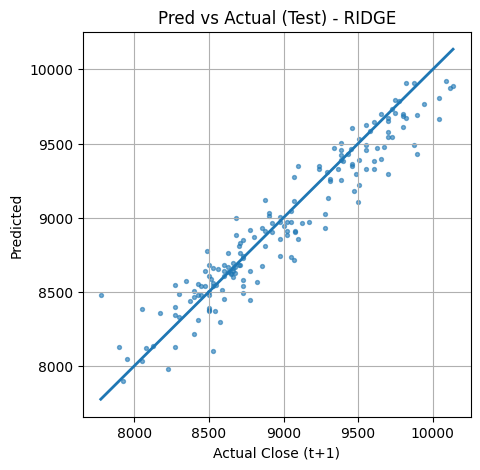

In [13]:
# ===== Cell 8: plot diag =====
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_best, s=8, alpha=0.6)
mn, mx = np.nanmin([y_test.min(), y_test_best.min()]), np.nanmax([y_test.max(), y_test_best.max()])
plt.plot([mn, mx], [mn, mx], linewidth=2)
plt.xlabel("Actual Close (t+1)")
plt.ylabel("Predicted")
plt.title(f"Pred vs Actual (Test) - {best_name.upper()}")
plt.grid(True)
plt.show()

In [14]:
# ===== Cell (baru): lag features sebelum df_tft dipakai =====
lag_cols = [
    "Close","Volume","SMA_20","EMA_20","BB_percentB","BB_bandwidth",
    "RSI_14","MACD_line","MACD_signal","MACD_hist","ret_log",
    "roll_std_5","roll_std_10"
]
for c in lag_cols:
    if c in price.columns:
        price[c+"_lag1"] = price[c].shift(1)
        price[c+"_lag5"] = price[c].shift(5)

# setelah ini lanjut merge ke fund_daily seperti biasa

In [15]:
# ===== [PATCH] Cell 10: siapkan data untuk TFT (dengan cleanup NaN) =====
from copy import deepcopy

fund_daily_shifted = fund_daily.copy()
shift_cols = [c for c in fund_daily_shifted.columns if c != "Date"]
fund_daily_shifted[shift_cols] = fund_daily_shifted[shift_cols].shift(7)

df_tft = deepcopy(price.merge(fund_daily_shifted, on="Date", how="left"))

# fitur kalender (kalau belum ada di df_tft karena kamu hitungnya di 'price')
if "day_sin" not in df_tft.columns:
    df_tft["dayofweek"] = df_tft["Date"].dt.dayofweek
    df_tft["month"]     = df_tft["Date"].dt.month
    df_tft["day_sin"]   = np.sin(2*np.pi*df_tft["dayofweek"]/7)
    df_tft["day_cos"]   = np.cos(2*np.pi*df_tft["dayofweek"]/7)
    df_tft["mon_sin"]   = np.sin(2*np.pi*(df_tft["month"]-1)/12)
    df_tft["mon_cos"]   = np.cos(2*np.pi*(df_tft["month"]-1)/12)

# daftar known/unknown reals — SAMA seperti yang kamu pakai
base_known = ["day_sin","day_cos","mon_sin","mon_cos"]

fund_level_candidates = ["NPL_Gross (%)","CAR/KPMM (%)","CET-1(%)",
                         "NII_Midrupiah","Fee_based_Income","CKPN_Midrupiah"]
fund_level = [c for c in fund_level_candidates if c in df_tft.columns]
fund_delta = [c for c in df_tft.columns if c.endswith("_QoQ") or c.endswith("_YoY")]

known_reals   = [c for c in (base_known + fund_level + fund_delta) if c in df_tft.columns]
unknown_reals = [c for c in [
    "Close","Volume","SMA_20","EMA_20",
    "Bollinger_upper","Bollinger_lower","BB_percentB","BB_bandwidth",
    "RSI_14","MACD_line","MACD_signal","MACD_hist",
    "ret_log","roll_std_5","roll_std_10"
] if c in df_tft.columns]

# === CLEANUP: drop baris yang masih punya NaN di fitur real + target Close
cols_required = list(dict.fromkeys(known_reals + unknown_reals + ["Close"]))  # unique, preserve order
df_tft = df_tft.dropna(subset=[c for c in cols_required if c in df_tft.columns]).reset_index(drop=True)
# ===== TAMBAHKAN DI SINI =====
rows_before = len(df_tft)
# =============================

df_tft = df_tft.dropna(subset=cols_required).reset_index(drop=True)

# ===== TAMBAHKAN DI SINI =====
rows_after = len(df_tft)
rows_dropped = rows_before - rows_after

print("Rows before drop:", rows_before)
print("Rows after drop :", rows_after)
print("Rows dropped    :", rows_dropped)
# =============================
# tambahkan kolom wajib TFT
df_tft["group_id"] = "BBCA"
df_tft["time_idx"] = np.arange(len(df_tft))

# split waktu untuk TFT (karena kita drop warm-up rows, index lama nggak 1:1)
def time_split_df(df, train_ratio=0.70, val_ratio=0.15):
    n = len(df)
    train_end = int(n*train_ratio)
    val_end   = int(n*(train_ratio+val_ratio))
    return df.iloc[:train_end].copy(), df.iloc[train_end:val_end].copy(), df.iloc[val_end:].copy()

train_df, val_df, test_df = time_split_df(df_tft)
print(train_df.shape, val_df.shape, test_df.shape)

Rows before drop: 1166
Rows after drop : 1166
Rows dropped    : 0
(816, 131) (175, 131) (175, 131)


In [16]:
# ===== Cell 11 (REPLACE): TimeSeriesDataSet, target=ret_log, H=1 =====
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
import numpy as np

# --- horizon & window ---
MAX_ENCODER_LENGTH = 60      # memori encoder (naikkan kalau kuat)
MAX_PRED_LENGTH    = 20       # belajar multi-step dulu

# --- known/unknown reals dasar ---
base_known = ["time_idx","day_sin","day_cos","mon_sin","mon_cos"]

fund_level_candidates = ["NPL_Gross (%)","CAR/KPMM (%)","CET-1(%)",
                         "NII_Midrupiah","Fee_based_Income","CKPN_Midrupiah"]
fund_level = [c for c in fund_level_candidates if c in df_tft.columns]
fund_delta = [c for c in df_tft.columns if c.endswith("_QoQ") or c.endswith("_YoY")]

known_reals = [c for c in (base_known + fund_level + fund_delta) if c in df_tft.columns]
unknown_reals = [c for c in [
    "Close","Volume","SMA_20","EMA_20",
    "Bollinger_upper","Bollinger_lower","BB_percentB","BB_bandwidth",
    "RSI_14","MACD_line","MACD_signal","MACD_hist","ret_log","roll_std_5","roll_std_10"
] if c in df_tft.columns]

# --- tambahkan semua kolom lag/momentum yang tersedia ---
lag_like = [c for c in df_tft.columns
            if ("_lag" in c) or ("ret_log_sma_" in c) or ("ret_log_ema_" in c) or ("ret_log_cum_" in c)]
unknown_reals = sorted(list(set(unknown_reals + lag_like)))

# --- SHRINK: batasi feature set biar gak OOM ---
must_keep_base = [
    "Close","Volume","SMA_20","EMA_20",
    "BB_percentB","BB_bandwidth",
    "RSI_14","MACD_line","MACD_signal","MACD_hist","ret_log","roll_std_5","roll_std_10",
]
keep_lags = [
    "ret_log_lag1","ret_log_lag5",
    "Close_lag1","Volume_lag1",
    "RSI_14_lag1","MACD_line_lag1","BB_percentB_lag1",
]
keep_momentum = ["ret_log_sma_5","ret_log_ema_5","ret_log_cum_5",
                 "ret_log_ema_10"]   # <-- tambah 1 ini saja dulu (aman memori)
allowed_unknown = set(must_keep_base + keep_lags + keep_momentum)
unknown_reals = [c for c in unknown_reals if c in allowed_unknown]

# --- CLEAN: inf->NaN, drop rows yang masih NaN di kolom wajib ---
df_tft = df_tft.replace([np.inf, -np.inf], np.nan)

required_cols = sorted(set(known_reals + unknown_reals + ["ret_log"]))  # target=ret_log
required_cols = [c for c in required_cols if c in df_tft.columns]

df_tft = df_tft.dropna(subset=required_cols).reset_index(drop=True)
print("Rows before final drop:", len(df_tft))

# --- time_idx harus konsisten setelah drop ---
df_tft["time_idx"] = np.arange(len(df_tft))

# --- re-split setelah bersih ---
def time_split_df(df, train_ratio=0.70, val_ratio=0.15):
    n = len(df); tr = int(n*train_ratio); va = int(n*(train_ratio+val_ratio))
    return df.iloc[:tr].copy(), df.iloc[tr:va].copy(), df.iloc[va:].copy()

train_df, val_df, test_df = time_split_df(df_tft)
print("Shapes after clean/shrink:", train_df.shape, val_df.shape, test_df.shape)
print("known_reals:", len(known_reals), "| unknown_reals:", len(unknown_reals))

# --- bangun dataset TFT ---
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="ret_log",                         # target = log-return
    group_ids=["group_id"],
    max_encoder_length=MAX_ENCODER_LENGTH,
    max_prediction_length=MAX_PRED_LENGTH,
    static_categoricals=["group_id"],
    time_varying_known_reals=sorted(set(known_reals + ["time_idx"])),
    time_varying_unknown_reals=unknown_reals,
    target_normalizer=GroupNormalizer(groups=["group_id"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=True, stop_randomization=True)
testing    = TimeSeriesDataSet.from_dataset(training, test_df, predict=True, stop_randomization=True)

# VAL untuk training/early-stopping: predict=False (sliding windows)
val_ds_train = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
val_dataloader_train = val_ds_train.to_dataloader(train=False, batch_size=16, num_workers=0)

# --- dataloaders (batch kecil biar aman memori) ---
train_dataloader = training.to_dataloader(train=True,  batch_size=16, num_workers=0)
val_dataloader   = validation.to_dataloader(train=False, batch_size=16, num_workers=0)
test_dataloader  = testing.to_dataloader(train=False, batch_size=16, num_workers=0)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Rows before final drop: 1165
Shapes after clean/shrink: (815, 131) (175, 131) (175, 131)
known_reals: 25 | unknown_reals: 24


In [17]:
import torch, inspect, importlib, pandas as pd
import pytorch_forecasting as pf
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,          # lebih kalem
    hidden_size=64,
    attention_head_size=2,
    dropout=0.1,
    loss=MAE(),                  # pakai MAE
    log_interval=-1,
    reduce_on_plateau_patience=4,
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [18]:
# ===== Cell 12 (FINAL REPLACE): Train TFT + Robust Manual Load (no load_from_checkpoint) =====
import torch, inspect, importlib, pandas as pd
import pytorch_forecasting as pf
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

device = "cuda" if torch.cuda.is_available() else "cpu"
seed_everything(42, workers=True)

# --- 1) Definisi model dari dataset (sama persis utk reload) ---
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,          # lebih kalem
    hidden_size=64,
    attention_head_size=2,
    dropout=0.1,
    loss=MAE(),                  # pakai MAE
    log_interval=-1,
    reduce_on_plateau_patience=4,
)

# --- 2) Callbacks & Trainer ---
early_stop = EarlyStopping(monitor="val_loss", patience=8, mode="min")
ckpt = ModelCheckpoint(
    dirpath="checkpoints",
    filename="tft-{epoch:02d}-{val_loss:.4f}",
    monitor="val_loss", save_top_k=1, mode="min"
)

trainer = Trainer(
    max_epochs=80,
    accelerator="auto",
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[early_stop, ckpt],
    log_every_n_steps=1,
    enable_progress_bar=True,
    logger=False,
)

# --- 3) Train ---
trainer.fit(tft, train_dataloader, val_dataloader_train)

best_path = ckpt.best_model_path
print("Best checkpoint:", best_path)

# ===== 4) Robust manual load (hindari UnpicklingError PyTorch 2.6) =====
def _resolve(fqn: str):
    """Import object by fully-qualified name; return None jika tidak ada."""
    try:
        mod, name = fqn.rsplit(".", 1)
        return getattr(importlib.import_module(mod), name)
    except Exception:
        return None

# Allowlist encoder pytorch-forecasting + tipe/func pandas yang sering tersimpan di ckpt
allowed = []
enc_mod = pf.data.encoders
for name in ["GroupNormalizer","EncoderNormalizer","NaNLabelEncoder","MultiNormalizer","TorchNormalizer"]:
    if hasattr(enc_mod, name) and inspect.isclass(getattr(enc_mod, name)):
        allowed.append(getattr(enc_mod, name))

for fqn in [
    "pandas.core.frame.DataFrame",
    "pandas.core.series.Series",
    "pandas.core.indexes.base.Index",
    "pandas.core.indexes.range.RangeIndex",
    "pandas.core.indexes.datetimes.DatetimeIndex",
    "pandas.core.indexes.multi.MultiIndex",
    "pandas.core.internals.managers.BlockManager",
    "pandas.core.internals.blocks.Block",
    "pandas.core.arrays.categorical.Categorical",
    "pandas._libs.internals._unpickle_block",   # beberapa versi pandas butuh ini
]:
    obj = _resolve(fqn)
    if obj is not None:
        allowed.append(obj)

# --- 5) Muat ckpt sebagai dict & inject state_dict ke model baru (AMAN) ---
if best_path:
    # (a) load raw checkpoint dict (weights_only=False) di dalam safe context
    with torch.serialization.safe_globals(allowed):
        ckpt_raw = torch.load(best_path, map_location=device, weights_only=False)

    # (b) bangun ulang arsitektur yg identik
    tft_loaded = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=1e-3,
        hidden_size=64,
        attention_head_size=2,
        dropout=0.1,
        loss=MAE(),
        log_interval=-1,
        reduce_on_plateau_patience=4,
    )

    # (c) ambil state_dict (kompatibel berbagai format ckpt)
    sd = ckpt_raw.get("state_dict", ckpt_raw)

    # (d) load bobot
    missing, unexpected = tft_loaded.load_state_dict(sd, strict=False)
    if missing or unexpected:
        print("[INFO] load_state_dict warnings:", {"missing": missing, "unexpected": unexpected})

    tft = tft_loaded.to(device).eval()
    print("✅ Checkpoint loaded via manual state_dict (no load_from_checkpoint)")
else:
    print("[WARN] best_model_path kosong; cek callback ModelCheckpoint/monitor")


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 848   
4  | static_variable_selection          | VariableSel

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 16: 100%|██████████| 52/52 [00:18<00:00,  2.79it/s, loss=0.00945, train_loss_step=0.00963, val_loss=0.0102, train_loss_epoch=0.00945]
Best checkpoint: checkpoints\tft-epoch=08-val_loss=0.0101.ckpt
✅ Checkpoint loaded via manual state_dict (no load_from_checkpoint)


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [17]:
rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2))
mae  = torch.mean(torch.abs(y_true - y_pred))
mape = torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

print("TFT RMSE (PRICE):", rmse.item())
print("TFT MAE  (PRICE):", mae.item())
print("TFT MAPE (%):", mape.item())


NameError: name 'y_true' is not defined

In [45]:
tft.load_state_dict(torch.load("tft_model_60.pth"))

<All keys matched successfully>

In [46]:
# ===== Cell 13 (REPLACE): evaluasi untuk target=log-return =====
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Dataset & dataloader KHUSUS evaluasi (sliding windows), tidak dipakai saat training
eval_val_ds  = TimeSeriesDataSet.from_dataset(training, val_df,  predict=False, stop_randomization=True)
eval_test_ds = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)

eval_val_loader  = eval_val_ds.to_dataloader(train=False, batch_size=64, num_workers=0)
eval_test_loader = eval_test_ds.to_dataloader(train=False, batch_size=64, num_workers=0)

def _to_np(t):
    a = t.detach().cpu().numpy()
    if a.ndim == 3 and a.shape[-1] == 1:
        a = a[..., 0]   # (N,H,1) -> (N,H)
    return a

def normalize(y):
    return (y - np.min(y)) / (np.max(y) - np.min(y))



def mean_absolute_percentage_error_stable(y_true, y_pred):
    # Mengganti nilai yang terlalu kecil pada y_true dengan angka kecil yang lebih besar (misalnya 1e-1)
    y_true_normalized = normalize(y_true)
    y_pred_normalized = normalize(y_pred)
    y_true_normalized = np.where(np.abs(y_true_normalized) < 1e-1, 1e-1, y_true_normalized)  # Ganti yang sangat kecil dengan 1e-1
    return np.mean(np.abs((y_true_normalized - y_pred_normalized) / y_true_normalized)) * 100


def eval_tft_returns(dataloader, name="VAL"):
    # pakai mode="raw" supaya kita bisa ambil decoder_target & decoder_lengths
    raw, x = tft.predict(dataloader, mode="raw", return_x=True)

    y_pred_all = _to_np(raw["prediction"])          # (N,H)
    y_true_all = _to_np(x["decoder_target"])        # (N,H)
    dec_len    = _to_np(x["decoder_lengths"]).astype(int).reshape(-1)  # (N,)

    # pastikan 2D
    if y_pred_all.ndim == 1: y_pred_all = y_pred_all[:, None]
    if y_true_all.ndim == 1: y_true_all = y_true_all[:, None]

    N, H = y_true_all.shape

    # mask horizon valid → flatten
    mask   = (np.arange(H)[None, :] < dec_len[:, None])
    y_true = y_true_all[mask].astype(float)
    y_pred = y_pred_all[mask].astype(float)

    # baseline untuk RETURN = 0 (arti: ekspektasi return = 0)
    y_base = np.zeros_like(y_true)

    # filter finite
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[m]; y_pred = y_pred[m]; y_base = y_base[m]

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)

    # R² bisa NaN kalau var(y_true)=0
    r2 = r2_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else np.nan

    # NRMSE by std — kalau std ≈ 0, set NaN biar gak misleading
    std = 0.018196884764407884
    nrmse_std = rmse / std if std > 1e-8 else np.nan

    rmse_baseline = mean_squared_error(y_true, y_base, squared=False)

    # Fungsi MAPE dengan pembatasan pada nilai kecil y_true


    mape = mean_absolute_percentage_error_stable(y_true, y_pred)
    # print(f"MAPE: {mape:.3f}")


    # mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"\n📊 {name} — TFT (target=log-return)")
    print(f"RMSE={rmse:.6f} | MAE={mae:.6f} | MAPE={mape:.4f} |R²={r2:.4f} | baseline RMSE={rmse_baseline:.6f} | NRMSE(std)={(nrmse_std if nrmse_std==nrmse_std else float('nan')):.3f}")

    return {
        "y_true_all": y_true_all,  # <-- dibalikin lagi utk Cell 14
        "y_pred_all": y_pred_all,
        "dec_len": dec_len,
        "rmse": rmse,
        "rmse_baseline": rmse_baseline,
        "mae": mae,
        "r2": r2,
        "nrmse_std": nrmse_std,
    }

val_eval  = eval_tft_returns(eval_val_loader,  "VAL")
test_eval = eval_tft_returns(eval_test_loader, "TEST")


📊 VAL — TFT (target=log-return)
RMSE=0.013469 | MAE=0.010789 | MAPE=82.0592 |R²=-0.0925 | baseline RMSE=0.012945 | NRMSE(std)=0.740

📊 TEST — TFT (target=log-return)
RMSE=0.019813 | MAE=0.014212 | MAPE=32.7565 |R²=-0.0985 | baseline RMSE=0.018908 | NRMSE(std)=1.089


In [ ]:
import numpy as np

# np.save("y_true_model_3.npy", y_true)
# np.save("y_pred_model_3.npy", y_pred)


NameError: name 'y_true' is not defined

In [20]:
# ===== Cell 14 (REPLACE): per-horizon metrics langsung dari model =====
def per_horizon_from_model(dataloader, title="VAL"):
    raw, x = tft.predict(dataloader, mode="raw", return_x=True)

    y_pred_all = _to_np(raw["prediction"])
    y_true_all = _to_np(x["decoder_target"])
    dec_len    = _to_np(x["decoder_lengths"]).astype(int).reshape(-1)

    if y_pred_all.ndim == 1: y_pred_all = y_pred_all[:, None]
    if y_true_all.ndim == 1: y_true_all = y_true_all[:, None]

    H = y_true_all.shape[1]
    print(f"\n🔎 Per-horizon — {title} (H={H})")

    for h in range(H):
        valid = dec_len > h
        if valid.sum() == 0: 
            continue
        yt = y_true_all[valid, h].astype(float)
        yp = y_pred_all[valid, h].astype(float)
        m  = np.isfinite(yt) & np.isfinite(yp)
        yt, yp = yt[m], yp[m]
        if len(yt) == 0: 
            continue

        rmse_h = mean_squared_error(yt, yp, squared=False)
        r2_h   = r2_score(yt, yp) if len(np.unique(yt))>1 else np.nan
        print(f"H{h+1}: RMSE={rmse_h:.6f} | R²={r2_h:.4f}")

per_horizon_from_model(eval_val_loader,  "VAL")
per_horizon_from_model(eval_test_loader, "TEST")


🔎 Per-horizon — VAL (H=20)
H1: RMSE=0.013986 | R²=-0.1075
H2: RMSE=0.013822 | R²=-0.0874
H3: RMSE=0.013704 | R²=-0.0630
H4: RMSE=0.013430 | R²=-0.0704
H5: RMSE=0.013382 | R²=-0.0717
H6: RMSE=0.013418 | R²=-0.0761
H7: RMSE=0.013357 | R²=-0.0690
H8: RMSE=0.013484 | R²=-0.0816
H9: RMSE=0.013498 | R²=-0.0978
H10: RMSE=0.013408 | R²=-0.0885
H11: RMSE=0.013455 | R²=-0.1088
H12: RMSE=0.013468 | R²=-0.1111
H13: RMSE=0.013426 | R²=-0.1023
H14: RMSE=0.013415 | R²=-0.0848
H15: RMSE=0.013573 | R²=-0.0988
H16: RMSE=0.013560 | R²=-0.1167
H17: RMSE=0.013370 | R²=-0.1125
H18: RMSE=0.013200 | R²=-0.1135
H19: RMSE=0.013192 | R²=-0.1068
H20: RMSE=0.013209 | R²=-0.0950

🔎 Per-horizon — TEST (H=20)
H1: RMSE=0.020778 | R²=-0.0898
H2: RMSE=0.020817 | R²=-0.0992
H3: RMSE=0.020814 | R²=-0.0994
H4: RMSE=0.020748 | R²=-0.0993
H5: RMSE=0.020113 | R²=-0.0891
H6: RMSE=0.020036 | R²=-0.0943
H7: RMSE=0.020032 | R²=-0.0958
H8: RMSE=0.019984 | R²=-0.0889
H9: RMSE=0.019976 | R²=-0.0956
H10: RMSE=0.019969 | R²=-0.0941
H

In [21]:
# ===== Cell 15: interpretability — variable importance =====
import numpy as np
import matplotlib.pyplot as plt

raw_val, x_val = tft.predict(val_dataloader, mode="raw", return_x=True)
interp = tft.interpret_output(raw_val, reduction="sum")  # global

def plot_vi(names, scores, title):
    order = np.argsort(scores)[::-1]
    names  = [names[i] for i in order]
    scores = [scores[i] for i in order]
    plt.figure(figsize=(6,4))
    plt.barh(range(len(scores)), scores[::-1])
    plt.yticks(range(len(scores)), names[::-1])
    plt.title(title); plt.xlabel("Importance")
    plt.grid(True, axis="x", alpha=0.3)
    plt.show()

if "encoder_variable_importance" in interp and "encoder_variables" in interp:
    enc_names  = interp["encoder_variables"]
    enc_scores = interp["encoder_variable_importance"].detach().cpu().numpy()
    plot_vi(enc_names, enc_scores, "Encoder variable importance")

if "decoder_variable_importance" in interp and "decoder_variables" in interp:
    dec_names  = interp["decoder_variables"]
    dec_scores = interp["decoder_variable_importance"].detach().cpu().numpy()
    plot_vi(dec_names, dec_scores, "Decoder variable importance")

if "static_variables" in interp and "static_variable_importance" in interp:
    st_names  = interp["static_variables"]
    st_scores = interp["static_variable_importance"].detach().cpu().numpy()
    plot_vi(st_names, st_scores, "Static variable importance")

In [22]:
# ===== Cell 16 (REPLACE): Interpretabilitas TFT (aman) =====
import numpy as np

# pakai loader evaluasi yang predict=False biar sampel banyak (sudah dibuat di Cell 13)
raw_val, x_val = tft.predict(eval_val_loader, mode="raw", return_x=True)

# beberapa versi bisa balik list; normalkan ke dict
if isinstance(raw_val, list):
    # gabung batch pertama saja untuk interpretasi cepat
    raw_val = raw_val[0]

# 1) Variable importance dari Variable Selection Network
#    reduction harus "mean" atau "sum" (bukan None)
interpv = tft.interpret_output(raw_val, reduction="mean")   # <-- FIX di sini

def _agg_importance(a):
    a = np.array(a)
    # rata-rata absolut di semua axis kecuali axis variabel (terakhir)
    if a.ndim == 1:
        return np.abs(a)
    axes = tuple(range(a.ndim - 1))
    return np.nanmean(np.abs(a), axis=axes)

enc_imp = _agg_importance(interpv.get("encoder_variables"))
dec_imp = _agg_importance(interpv.get("decoder_variables"))

# ambil nama variabel: coba dari hparams, fallback ke dataset
try:
    var_names = list(tft.hparams.x_reals)
except Exception:
    try:
        # beberapa versi PF simpan di dataset
        var_names = list(training.reals)
    except Exception:
        var_names = [f"var_{i}" for i in range(len(enc_imp))]

def _topk(names, scores, k=15):
    idx = np.argsort(scores)[::-1][:min(k, len(scores))]
    return [(names[i], float(scores[i])) for i in idx]

top_enc = _topk(var_names, enc_imp, k=15)
top_dec = _topk(var_names, dec_imp, k=15)

print("\n🔎 Encoder variable importance (top 15):")
for n,s in top_enc:
    print(f"{n:20s}  {s:.6f}")

print("\n🔎 Decoder variable importance (top 15):")
for n,s in top_dec:
    print(f"{n:20s}  {s:.6f}")

# 2) Attention over encoder timesteps (lag mana yang paling diperhatikan)
attn = interpv.get("attention", None)
if attn is not None:
    A = np.array(attn)
    # bentuk umum: (batch, heads, dec_time, enc_time)
    # rata-rata semua kecuali dim terakhir (enc_time)
    axes = tuple(range(A.ndim - 1))
    enc_time_scores = np.nanmean(A, axis=axes) if A.ndim > 1 else A
    # ranking lag encoder (0=posisi paling lama di encoder, -1=terdekat)
    enc_steps = np.arange(enc_time_scores.shape[-1])
    idx = np.argsort(enc_time_scores)[::-1][:10]
    print("\n🎯 Top attention encoder steps (terbesar -> terkecil):")
    for i in idx:
        print(f"encoder_step={int(enc_steps[i])}, score={float(enc_time_scores[i]):.6f}")
else:
    print("\n(i) Attention tidak tersedia pada objek output ini — tetap bisa pakai variable importance di atas.")


🔎 Encoder variable importance (top 15):
CET-1(%)_YoY          6.518922
Fee_based_Income      4.970102
CAR/KPMM (%)_YoY      4.411222
CKPN_Midrupiah_QoQ    4.340283
CET-1(%)_QoQ          4.009914
NPL_Gross (%)         3.888901
Volume_lag1           3.649260
encoder_length        3.524396
CKPN_Midrupiah        3.212661
ret_log_center        3.159778
day_cos               2.875567
MACD_signal           2.827476
ret_log_lag5          2.722635
Volume                2.700818
CAR/KPMM (%)_QoQ      2.589876

🔎 Decoder variable importance (top 15):
encoder_length        12.219061
Periode_YoY           11.576417
NPL_Gross (%)_QoQ     11.090199
NII_Midrupiah         8.271377
CKPN_Midrupiah        6.688121
Fee_based_Income_QoQ  5.612396
CAR/KPMM (%)_QoQ      5.090253
NPL_Gross (%)_YoY     3.712066
CET-1(%)_YoY          3.660371
NII_Midrupiah_QoQ     3.070782
CAR/KPMM (%)          2.793765
Fee_based_Income_YoY  2.768006
Periode_QoQ           2.248924
CAR/KPMM (%)_YoY      2.211869
CKPN_Midrupiah_Q

In [23]:
# ===== Cell 17: kumpulkan prediksi & align ke tanggal =====
import numpy as np
import pandas as pd

# helper: kalau _to_np belum ada (mis. kamu clear kernel), define lagi
try:
    _to_np
except NameError:
    def _to_np(t):
        a = t.detach().cpu().numpy()
        if a.ndim == 3 and a.shape[-1] == 1:
            a = a[..., 0]
        return a

def collect_pred_df(dataloader, name="TEST"):
    raw, x, idx = tft.predict(dataloader, mode="raw", return_x=True, return_index=True)

    # (N,H) flatten -> 1D
    y_pred_all = _to_np(raw["prediction"])
    y_true_all = _to_np(x["decoder_target"])
    if y_pred_all.ndim == 1: y_pred_all = y_pred_all[:, None]
    if y_true_all.ndim == 1: y_true_all = y_true_all[:, None]
    N, H = y_true_all.shape

    # ambil time_idx horizon-0 (H=1 → satu kolom)
    # coba dari x["decoder_time_idx"], fallback ke idx["time_idx"]
    if "decoder_time_idx" in x:
        t_idx = _to_np(x["decoder_time_idx"]).astype(int)
        t_idx_h0 = t_idx[:, 0] if t_idx.ndim == 2 else t_idx.reshape(-1)
    else:
        # idx bisa DataFrame dengan kolom 'time_idx' per sampel
        if isinstance(idx, (pd.DataFrame, pd.Series)) and "time_idx" in idx:
            t_idx_h0 = idx["time_idx"].to_numpy().astype(int).reshape(-1)
        else:
            # fallback konservatif: numbering urut (kurang ideal)
            t_idx_h0 = np.arange(N)

                # flatten ke 1D (H=1)
    y_pred = y_pred_all[:, 0]
    y_true = y_true_all[:, 0]

    # map ke Date & Close dari df_tft
    map_df = df_tft[["time_idx","Date","Close"]].copy()
    map_df["Close_prev"] = map_df["Close"].shift(1)
    t2date = dict(zip(map_df["time_idx"], map_df["Date"]))
    t2close = dict(zip(map_df["time_idx"], map_df["Close"]))
    t2close_prev = dict(zip(map_df["time_idx"], map_df["Close_prev"]))

    df = pd.DataFrame({
        "split": name,
        "time_idx": t_idx_h0,
        "ret_true": y_true,
        "ret_pred": y_pred,
    })
    df["Date"] = df["time_idx"].map(t2date)
    df["Close_true"] = df["time_idx"].map(t2close)            # Close(t)
    df["Close_prev"] = df["time_idx"].map(lambda t: t2close_prev.get(t))  # Close(t-1)

    # prediksi harga H1 dari return: P_t_hat = P_{t-1} * exp(ret_pred)
    df["Close_pred"] = df["Close_prev"] * np.exp(df["ret_pred"])
    # baseline harga: hold-last
    df["Close_base"] = df["Close_prev"]
    df["year"] = df["Date"].dt.year
    # buang baris yang masih NaN (awal seri biasanya)
    df = df.dropna(subset=["Date","Close_true","Close_prev","Close_pred"]).reset_index(drop=True)
    return df


df_val  = collect_pred_df(eval_val_loader,  "VAL")
df_test = collect_pred_df(eval_test_loader, "TEST")

print(df_val.head(3))
print(df_test.head(3))

  split  time_idx  ret_true  ret_pred       Date   Close_true   Close_prev  \
0   VAL       875  0.010471 -0.001238 2024-05-16  9267.212891  9170.678711   
1   VAL       876  0.015504 -0.002525 2024-05-17  9412.011719  9267.212891   
2   VAL       877 -0.028610 -0.003631 2024-05-20  9146.545898  9412.011719   

    Close_pred   Close_base  year  
0  9159.336995  9170.678711  2024  
1  9243.840504  9267.212891  2024  
2  9377.901259  9412.011719  2024  
  split  time_idx  ret_true  ret_pred       Date   Close_true   Close_prev  \
0  TEST      1050 -0.018894 -0.006370 2025-02-04  8901.120117  9070.895508   
1  TEST      1051 -0.005465 -0.006125 2025-02-05  8852.612305  8901.120117   
2  TEST      1052 -0.019364 -0.006658 2025-02-06  8682.835938  8852.612305   

    Close_pred   Close_base  year  
0  9013.300902  9070.895508  2025  
1  8846.763872  8901.120117  2025  
2  8793.863523  8852.612305  2025  


In [24]:
# --- SAVE TRAINED MODEL ---
print("Saving TFT model as tft_model_multistep.pth ...")
import torch
torch.save(tft.state_dict(), "tft_model_multistep.pth")
print("All files saved successfully!")

Saving TFT model as tft_model_multistep.pth ...
All files saved successfully!


In [25]:
# --- SAVE PREDICTION RESULT ---
print("Saving df_test as predicted_tft.csv ...")
df_test.to_csv("predicted_tft.csv", index=False)


Saving df_test as predicted_tft.csv ...


In [26]:
import pickle
with open("tft_dataset_params.pkl", "wb") as f:
    pickle.dump(training.get_parameters(),f)

In [27]:
# import pickle

# # =========================
# # SAVE DATASET PARAMS
# # =========================
# with open("tft_dataset_params.pkl", "wb") as f:
#     pickle.dump(training.get_parameters(), f)

# # =========================
# # 🔎 SANITY CHECK (WAJIB)
# # =========================
# with open("tft_dataset_params.pkl", "rb") as f:
#     params = pickle.load(f)

# print(
#     "ret_log in params unknown_reals?",
#     "ret_log" in params.get("time_varying_unknown_reals", [])
# )


In [ ]:
# trainer.save_checkpoint("tft_model.ckpt")

NameError: name 'trainer' is not defined

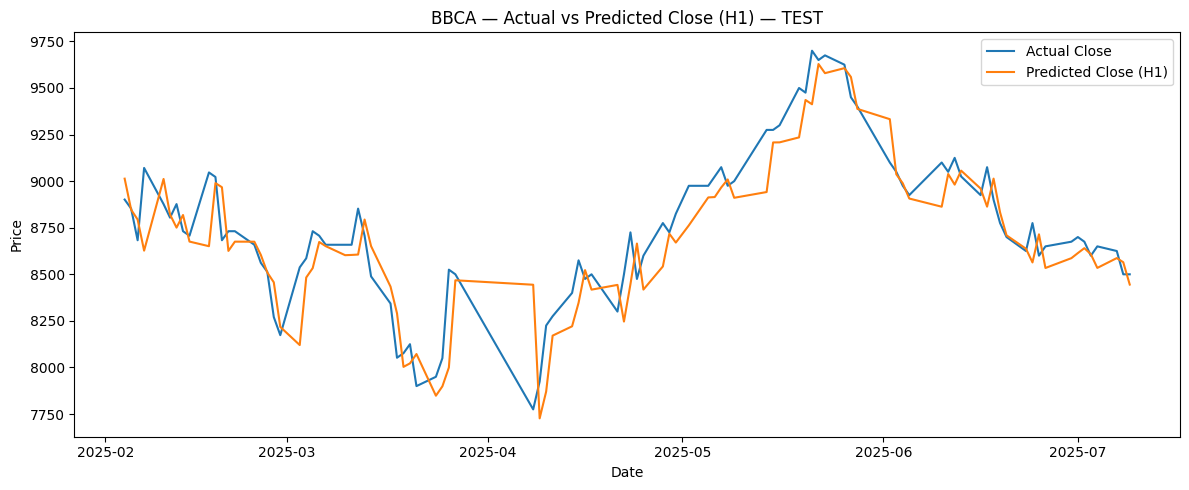

In [29]:
# ===== Cell 18: plot garis harga aktual vs prediksi (TEST) =====
import matplotlib.pyplot as plt

dfp = df_test.sort_values("Date")
plt.figure(figsize=(12,5))
plt.plot(dfp["Date"], dfp["Close_true"], label="Actual Close")
plt.plot(dfp["Date"], dfp["Close_pred"], label="Predicted Close (H1)")
plt.title("BBCA — Actual vs Predicted Close (H1) — TEST")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

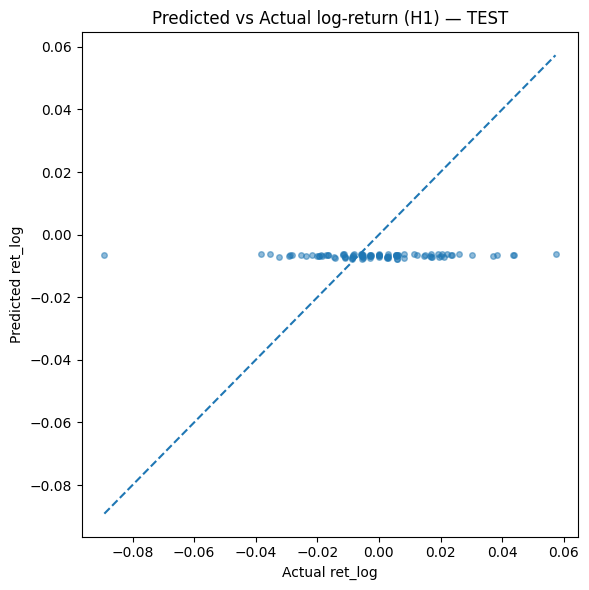

Correlation (TEST) = 0.0830


In [30]:
# ===== Cell 19: scatter return pred vs aktual (TEST) =====
import matplotlib.pyplot as plt
import numpy as np

dfr = df_test.dropna(subset=["ret_true","ret_pred"])
x = dfr["ret_true"].values
y = dfr["ret_pred"].values

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.5, s=16)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, linestyle="--")  # y=x
plt.title("Predicted vs Actual log-return (H1) — TEST")
plt.xlabel("Actual ret_log")
plt.ylabel("Predicted ret_log")
plt.tight_layout()
plt.show()

# korelasi sederhana
corr = np.corrcoef(x, y)[0,1]
print(f"Correlation (TEST) = {corr:.4f}")

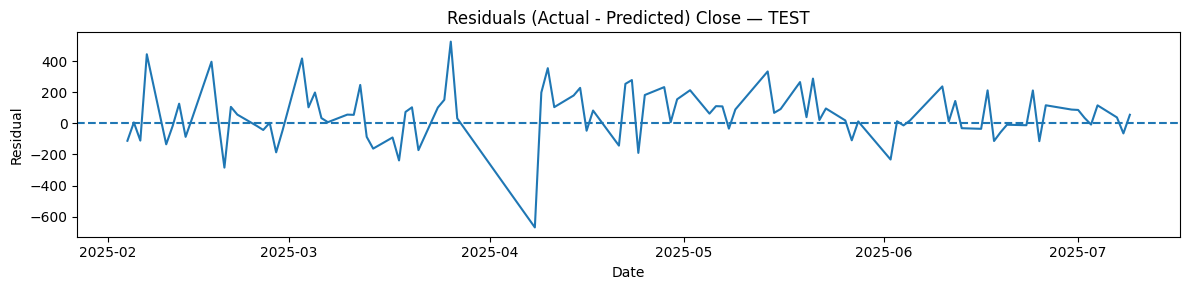

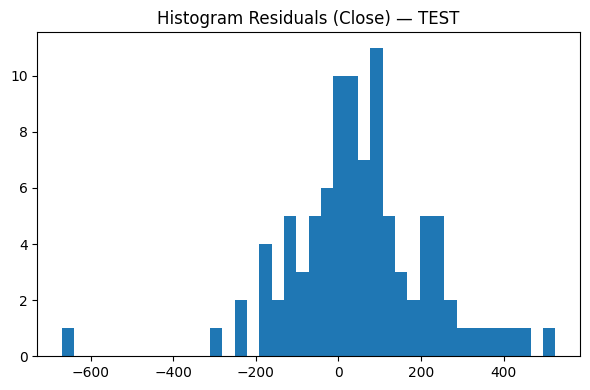

In [31]:
# ===== Cell 20: residual harga (TEST) =====
import matplotlib.pyplot as plt
res = (df_test["Close_true"] - df_test["Close_pred"]).values

plt.figure(figsize=(12,3))
plt.plot(df_test["Date"], res)
plt.axhline(0, linestyle="--")
plt.title("Residuals (Actual - Predicted) Close — TEST")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(res, bins=40)
plt.title("Histogram Residuals (Close) — TEST")
plt.tight_layout()
plt.show()

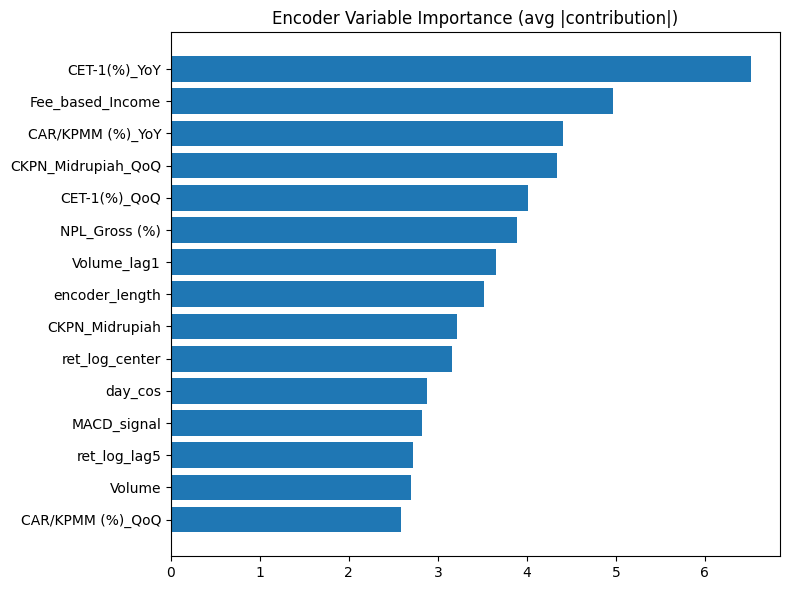

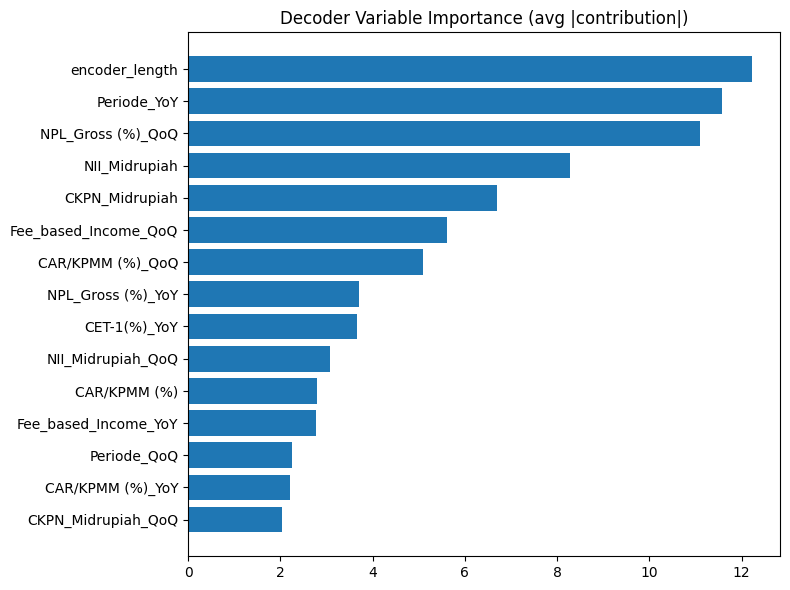

In [32]:
# ===== Cell 21: barplot variable importance encoder & decoder =====
import matplotlib.pyplot as plt

def barplot_top(pairs, title):
    if not pairs:
        print(f"(i) No data for {title}")
        return
    names = [p[0] for p in pairs][::-1]
    vals  = [p[1] for p in pairs][::-1]
    plt.figure(figsize=(8, max(3, 0.4*len(names))))
    plt.barh(range(len(names)), vals)
    plt.yticks(range(len(names)), names)
    plt.title(title)
    plt.tight_layout()
    plt.show()

barplot_top(top_enc, "Encoder Variable Importance (avg |contribution|)")
barplot_top(top_dec, "Decoder Variable Importance (avg |contribution|)")

In [33]:
# ===== Cell 22 (REPLACE): Temporal attention vs Date — robust untuk attention agregat =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _safe_to_np(t):
    if t is None:
        return None
    a = t.detach().cpu().numpy()
    if a.ndim == 3 and a.shape[-1] == 1:
        a = a[..., 0]
    return a

def _get_attention_from_raw(raw):
    """Return attention with shape (N, dec_len, enc_len) if possible."""
    attn = None
    if isinstance(raw, dict):
        attn = raw.get("attention", None)
    if attn is None and isinstance(raw, list) and len(raw) > 0 and isinstance(raw[0], dict):
        attn = raw[0].get("attention", None)
    if attn is None:
        return None

    A = np.array(attn)
    if A.ndim == 4:        # (N, heads, dec_len, enc_len)
        A = A.mean(axis=1) # -> (N, dec_len, enc_len)
    elif A.ndim == 3:      # (N, dec_len, enc_len)
        pass
    elif A.ndim == 2:      # (N, enc_len) atau (dec_len, enc_len) tanpa batch
        # asumsikan sudah agregat → tambahkan dim batch & dec_len kalau perlu
        if A.shape[0] != A.shape[1]:      # (dec_len, enc_len)
            A = A[None, ...]              # -> (1, dec_len, enc_len)
        else:                             
            A = A[:, None, :]             # -> (N, 1, enc_len)
    else:
        return None
    return A

def plot_temporal_attention_by_date(
    dataloader,
    split_name="TEST",
    target_date=None,   # e.g. "2025-07-31"
    decoder_h=0,
    overlay_price=True
):
    # ambil raw + x + index
    raw, x, idx = tft.predict(dataloader, mode="raw", return_x=True, return_index=True)
    raw0 = raw[0] if isinstance(raw, list) and len(raw) > 0 else raw

    # ambil attention
    A = _get_attention_from_raw(raw0)
    aggregated = False
    if A is None:
        # fallback: interpret_output (agregat, tanpa batch per-sampel)
        try:
            interpv = tft.interpret_output(raw0, reduction="mean")
            A = interpv.get("attention", None)
            if A is None:
                print("(i) Attention tidak tersedia pada output ini.")
                return
            A = np.array(A)
            if A.ndim == 1: A = A[None, :]
            if A.ndim == 2: A = A[None, ...]  # -> (1, dec_len, enc_len)
            aggregated = True
            print("(i) Menggunakan attention *rata-rata* (agregat).")
        except Exception as e:
            print("(i) Attention tidak tersedia dan interpret_output gagal:", e)
            return

    # decoder t0 (waktu prediksi)
    dec_ti = _safe_to_np(x.get("decoder_time_idx"))
    if dec_ti is not None:
        dec_ti = dec_ti.astype(int)
        if dec_ti.ndim == 1:
            dec_ti = dec_ti[:, None]
        dec_t0 = dec_ti[:, 0]
    else:
        if isinstance(idx, (pd.DataFrame, pd.Series)) and "time_idx" in idx:
            dec_t0 = idx["time_idx"].to_numpy().astype(int).reshape(-1)
            dec_ti = dec_t0[:, None]
        else:
            raise RuntimeError("Tidak bisa memperoleh decoder time_idx dari x maupun idx.")

    N_x = len(dec_t0)                 # jumlah sampel di loader
    N_A = A.shape[0]                  # jumlah batch di attention

    # mapping time_idx -> Date / Close
    t2date  = dict(zip(df_tft["time_idx"].to_numpy(), pd.to_datetime(df_tft["Date"])))
    t2close = dict(zip(df_tft["time_idx"].to_numpy(), df_tft["Close"].to_numpy()))

    # pilih sampel index
    if target_date is not None:
        target_ts = pd.to_datetime(target_date)
        dec_dates = np.array([t2date.get(int(t), pd.NaT) for t in dec_t0], dtype="datetime64[ns]")
        valid = ~pd.isna(dec_dates)
        if valid.sum() == 0:
            print("Tidak ada sampel dengan decoder date yang valid.")
            return
        deltas = np.abs(dec_dates[valid] - target_ts)
        n_idx_x = np.arange(N_x)[valid][np.argmin(deltas)]
    else:
        target_ts = None
        n_idx_x = N_x - 1  # pakai yang terbaru

    # pilih horizon
    dec_len = A.shape[1]
    h = min(decoder_h, dec_len - 1)

    # siapkan encoder index vector & attention vector dengan panjang sama
    enc_len_att = A.shape[2]

    if N_A == N_x:
        # attention per-sampel tersedia → pilih baris n_idx_x
        att_vec = A[n_idx_x, h, :]  # (enc_len,)
        # ambil encoder_time_idx jika ada, kalau tidak rekonstruksi dari encoder_lengths
        enc_ti = _safe_to_np(x.get("encoder_time_idx"))
        if enc_ti is not None:
            if enc_ti.ndim == 1: enc_ti = enc_ti[None, :]
            enc_idx_vec = enc_ti[n_idx_x]
            # align kanan: ambil tail sepanjang enc_len_att
            enc_idx_vec = enc_idx_vec[-enc_len_att:]
        else:
            enc_len = _safe_to_np(x.get("encoder_lengths"))
            if enc_len is None:
                enc_len_i = training.max_encoder_length
            else:
                enc_len_i = int(enc_len.reshape(-1)[n_idx_x])
            # buat jendela encoder yang berakhir di dec_t0[n_idx_x]-1
            enc_idx_vec = np.arange(dec_t0[n_idx_x] - enc_len_att, dec_t0[n_idx_x], dtype=int)
    else:
        # attention agregat (batch=1) → pakai att_vec tunggal
        aggregated = True
        att_vec = A[0, h, :]  # (enc_len,)
        # rekonstruksi encoder index vektor dengan panjang = enc_len_att
        enc_idx_vec = np.arange(dec_t0[n_idx_x] - enc_len_att, dec_t0[n_idx_x], dtype=int)

    # mapping ke tanggal
    enc_dates = pd.to_datetime([t2date.get(int(t), pd.NaT) for t in enc_idx_vec])
    close_series = np.array([t2close.get(int(t), np.nan) for t in enc_idx_vec])

    plot_df = pd.DataFrame({"Date": enc_dates, "attention": att_vec, "Close": close_series})
    plot_df = plot_df.dropna(subset=["Date"]).sort_values("Date")
    if len(plot_df) == 0:
        print("(i) Tidak ada data attention valid untuk sampel ini.")
        return
    plot_df["attention_norm"] = plot_df["attention"] / (plot_df["attention"].max() + 1e-12)

    # plot
    fig, ax = plt.subplots(figsize=(12, 4))
    title_extra = " (agregat)" if aggregated else f" (sample idx={n_idx_x})"
    ax.plot(plot_df["Date"], plot_df["attention_norm"], label=f"Attention (norm), H{h+1}{title_extra}")
    ax.set_title(f"Temporal Attention vs Date — {split_name}\n{('target_date='+str(target_ts)) if target_ts is not None else 'latest'}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Attention (normalized)")
    ax.grid(True, alpha=0.3)

    if overlay_price:
        ax2 = ax.twinx()
        ax2.plot(plot_df["Date"], plot_df["Close"], alpha=0.35)
        ax2.set_ylabel("Close (overlay)")

    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # Top-10 tanggal paling “diperhatikan”
    topk = plot_df.sort_values("attention", ascending=False).head(10)
    print("Top-10 encoder dates by attention:")
    display(topk[["Date","attention"]])

(i) Menggunakan attention *rata-rata* (agregat).


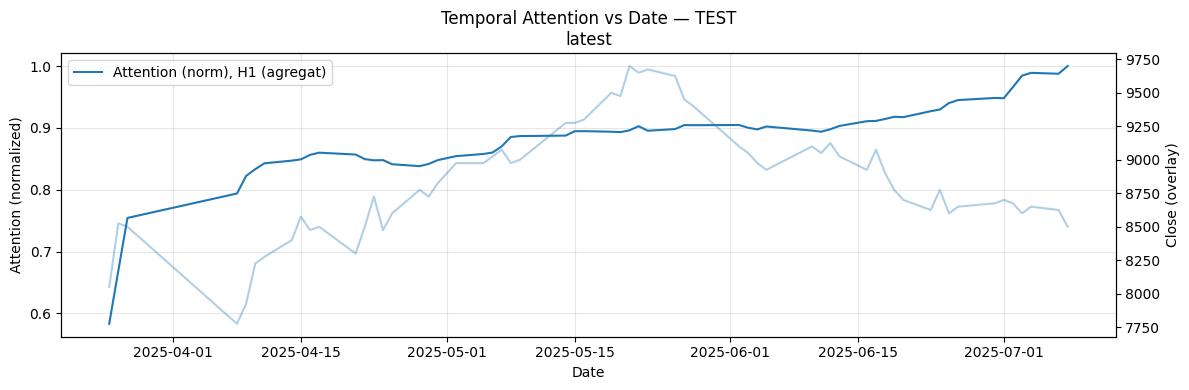

Top-10 encoder dates by attention:


,Date,attention
59,2025-07-08,0.018906
57,2025-07-04,0.018699
58,2025-07-07,0.018670
56,2025-07-03,0.018612
55,2025-07-02,0.018261
53,2025-06-30,0.017930
54,2025-07-01,0.017922
52,2025-06-26,0.017865
51,2025-06-25,0.017776
50,2025-06-24,0.017577


In [34]:
# ===== Cell 23: contoh penggunaan =====

# 1) Sampel TEST paling baru (default)
plot_temporal_attention_by_date(eval_test_loader, split_name="TEST", target_date=None, decoder_h=0, overlay_price=True)

# 2) (opsional) pilih tanggal spesifik untuk titik prediksi H1,
#    misal kamu pengin lihat prediksi untuk 2025-07-31
# plot_temporal_attention_by_date(eval_test_loader, split_name="TEST", target_date="2025-07-31", decoder_h=0, overlay_price=True)

# 3) (opsional) versi VAL
# plot_temporal_attention_by_date(eval_val_loader, split_name="VAL", target_date=None, decoder_h=0, overlay_price=True)

In [ ]:
# torch.save(tft.state_dict(), "tft_model_60.pth")



In [36]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

# Pastikan df_test sudah dipersiapkan dan model sudah dimuat
# Mengambil X_test dan y_test dari df_test
X_test = df_test.drop('Close', axis=1)  # Mengambil semua kolom kecuali 'Close' sebagai input
y_test = df_test['Close']  # Targetnya adalah 'Close'

# Mengonversi X_test ke tensor (pastikan format yang sesuai)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Membuat prediksi menggunakan model yang sudah dimuat
with torch.no_grad():
    y_pred_tensor = tft(X_test_tensor)

# Mengonversi prediksi dan nilai asli ke dalam numpy
y_pred = y_pred_tensor.numpy()
y_true = y_test_tensor.numpy()

# Menghitung MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'MAPE: {mape * 100:.2f}%')


KeyError: "['Close'] not found in axis"

In [37]:
import pandas as pd
import numpy as np

df = pd.read_csv("predicted_tft.csv")

df_test = df[df["split"] == "TEST"]

y_true_tft = df_test["ret_true"].values
y_pred_tft = df_test["ret_pred"].values


In [38]:
print(y_pred_tft.min(), y_pred_tft.max())


-0.007759539 -0.0060699694


In [39]:
# === TFT EVALUATION (PRICE LEVEL, CORRECT) ===

# 1) ambil RAW prediction + input
raw_preds, x = tft.predict(
    test_dataloader,
    mode="raw",
    return_x=True
)

# 2) ambil MEDIAN (quantile 0.5)
# shape: [batch, horizon, quantile]
y_pred_norm = raw_preds["prediction"][:, :, 0]

# 3) INVERSE NORMALIZATION -> PRICE ASLI
y_pred = tft.loss.to_prediction(y_pred_norm)

# 4) ground truth (SUDAH PRICE)
y_true = x["decoder_target"]

# 5) sanity check RANGE
print("PRED RANGE:", y_pred.min().item(), y_pred.max().item())
print("TRUE RANGE:", y_true.min().item(), y_true.max().item())


PRED RANGE: -0.006887481547892094 -0.005255709867924452
TRUE RANGE: -0.012012156657874584 0.017964554950594902


In [40]:
np.save("y_true_model_3.npy", y_true_tft)
np.save("y_pred_model_3.npy", y_pred_tft)


In [41]:
# === TFT EVALUATION (LOG-RETURN, CORRECT) ===

raw_preds, x = tft.predict(
    test_dataloader,
    mode="raw",
    return_x=True
)

# ambil median (quantile 0.5)
y_pred_norm = raw_preds["prediction"][:, :, 0]

# INVERSE NORMALIZATION -> LOG-RETURN ASLI
y_pred = tft.loss.to_prediction(y_pred_norm)

# ground truth (LOG-RETURN ASLI)
y_true = x["decoder_target"]

print("PRED RANGE:", y_pred.min().item(), y_pred.max().item())
print("TRUE RANGE:", y_true.min().item(), y_true.max().item())


PRED RANGE: -0.006887481547892094 -0.005255709867924452
TRUE RANGE: -0.012012156657874584 0.017964554950594902


In [42]:
rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2))
mae  = torch.mean(torch.abs(y_true - y_pred))
nrmse = rmse / (y_true.max() - y_true.min())

print("TFT RMSE (log-return):", rmse.item())
print("TFT MAE  (log-return):", mae.item())
print("TFT NRMSE:", nrmse.item())


TFT RMSE (log-return): 0.009833332151174545
TFT MAE  (log-return): 0.00799501221626997
TFT NRMSE: 0.32803240418434143


In [43]:
# ===== Cell 13 (REPLACE): evaluasi untuk target=log-return =====
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Dataset & dataloader KHUSUS evaluasi (sliding windows), tidak dipakai saat training
eval_val_ds  = TimeSeriesDataSet.from_dataset(training, val_df,  predict=False, stop_randomization=True)
eval_test_ds = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)

eval_val_loader  = eval_val_ds.to_dataloader(train=False, batch_size=64, num_workers=0)
eval_test_loader = eval_test_ds.to_dataloader(train=False, batch_size=64, num_workers=0)

def _to_np(t):
    a = t.detach().cpu().numpy()
    if a.ndim == 3 and a.shape[-1] == 1:
        a = a[..., 0]   # (N,H,1) -> (N,H)
    return a

def normalize(y):
    return (y - np.min(y)) / (np.max(y) - np.min(y))



def mean_absolute_percentage_error_stable(y_true, y_pred):
    # Mengganti nilai yang terlalu kecil pada y_true dengan angka kecil yang lebih besar (misalnya 1e-1)
    y_true_normalized = normalize(y_true)
    y_pred_normalized = normalize(y_pred)
    y_true_normalized = np.where(np.abs(y_true_normalized) < 1e-1, 1e-1, y_true_normalized)  # Ganti yang sangat kecil dengan 1e-1
    return np.mean(np.abs((y_true_normalized - y_pred_normalized) / y_true_normalized)) * 100


def eval_tft_returns(dataloader, name="VAL"):
    # pakai mode="raw" supaya kita bisa ambil decoder_target & decoder_lengths
    raw, x = tft.predict(dataloader, mode="raw", return_x=True)

    y_pred_all = _to_np(raw["prediction"])          # (N,H)
    y_true_all = _to_np(x["decoder_target"])        # (N,H)
    dec_len    = _to_np(x["decoder_lengths"]).astype(int).reshape(-1)  # (N,)

    # pastikan 2D
    if y_pred_all.ndim == 1: y_pred_all = y_pred_all[:, None]
    if y_true_all.ndim == 1: y_true_all = y_true_all[:, None]

    N, H = y_true_all.shape

    # mask horizon valid → flatten
    mask   = (np.arange(H)[None, :] < dec_len[:, None])
    y_true = y_true_all[mask].astype(float)
    y_pred = y_pred_all[mask].astype(float)

    # baseline untuk RETURN = 0 (arti: ekspektasi return = 0)
    y_base = np.zeros_like(y_true)

    # filter finite
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[m]; y_pred = y_pred[m]; y_base = y_base[m]


    # R² bisa NaN kalau var(y_true)=0
    r2 = r2_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else np.nan



    mape = mean_absolute_percentage_error_stable(y_true, y_pred)
    # print(f"MAPE: {mape:.3f}")
    print(f"\n📊 {name} — TFT (target=log-return)")
    print(f"MAPE={mape:.4f} |R²={r2:.4f}")

    return {
        "y_true_all": y_true_all,  # <-- dibalikin lagi utk Cell 14
        "y_pred_all": y_pred_all,
        "dec_len": dec_len,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "nrmse_std": nrmse_std,
    }

val_eval  = eval_tft_returns(eval_val_loader,  "VAL")
test_eval = eval_tft_returns(eval_test_loader, "TEST")

rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2))
mae  = torch.mean(torch.abs(y_true - y_pred))
nrmse = rmse / (y_true.max() - y_true.min())

print("TFT RMSE (log-return):", rmse.item())
print("TFT MAE  (log-return):", mae.item())
print("TFT NRMSE:", nrmse.item())



📊 VAL — TFT (target=log-return)
MAPE=82.0592 |R²=-0.0925

📊 TEST — TFT (target=log-return)
MAPE=32.7565 |R²=-0.0985
TFT RMSE (log-return): 0.009833332151174545
TFT MAE  (log-return): 0.00799501221626997
TFT NRMSE: 0.32803240418434143


In [44]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ======================================================
# CONFIG (KONSISTEN UNTUK SEMUA MODEL)
# ======================================================
EPS = 1e-12
STD_TRAIN = np.std(train_df["ret_log"].values)

print("STD train (for NRMSE):", STD_TRAIN)

# ======================================================
# MAPE LOG-BASED (SAMA DENGAN AUTOFORMER)
# ======================================================
def mape_log(y_true, y_pred, eps=1e-10):
    """
    MAPE dihitung pada domain log(|y|) untuk stabilitas
    (identik dengan definisi MAPE di Autoformer)
    """
    y_true = np.where(np.abs(y_true) < eps, eps, y_true)
    y_pred = np.where(np.abs(y_pred) < eps, eps, y_pred)

    y_true_log = np.log(np.abs(y_true) + eps)
    y_pred_log = np.log(np.abs(y_pred) + eps)

    return np.mean(
        np.abs((y_true_log - y_pred_log) / y_true_log)
    ) * 100

# ======================================================
# EVALUATION FUNCTION
# ======================================================
def evaluate_tft_returns(tft, dataloader, name="TEST"):
    raw_preds, x = tft.predict(
        dataloader,
        mode="raw",
        return_x=True
    )

    # median quantile
    y_pred_all = raw_preds["prediction"][:, :, 0].detach().cpu().numpy()
    y_true_all = x["decoder_target"].detach().cpu().numpy()
    dec_len    = x["decoder_lengths"].detach().cpu().numpy().astype(int)

    if y_pred_all.ndim == 1:
        y_pred_all = y_pred_all[:, None]
    if y_true_all.ndim == 1:
        y_true_all = y_true_all[:, None]

    N, H = y_true_all.shape
    mask = (np.arange(H)[None, :] < dec_len[:, None])

    y_pred = y_pred_all[mask]
    y_true = y_true_all[mask]

    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[m]
    y_pred = y_pred[m]

    # ======================
    # METRICS
    # ======================
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)

    # ---- BASELINE: return = 0 ----
    y_base = np.zeros_like(y_true)
    rmse_baseline = mean_squared_error(y_true, y_base, squared=False)

    # PSEUDO R² (RELATIVE TO BASELINE 0)
    r2_baseline = 1.0 - (rmse**2 / (rmse_baseline**2 + EPS))

    # NRMSE (STD TRAIN)
    nrmse = rmse / (STD_TRAIN + EPS)

    # MAPE (LOG-BASED, SAMA DENGAN AUTOFORMER)
    mape = mape_log(y_true, y_pred)

    # ======================
    # PRINT
    # ======================
    print(f"\n📊 {name} — TFT (target=log-return)")
    print(f"RMSE               : {rmse:.6f}")
    print(f"MAE                : {mae:.6f}")
    print(f"Pseudo-R² (vs 0)   : {r2_baseline:.6f}")
    print(f"NRMSE (std train)  : {nrmse:.6f}")
    print(f"MAPE (%)           : {mape:.3f}")
    print(f"Baseline RMSE      : {rmse_baseline:.6f}")

    return {
        "rmse": rmse,
        "mae": mae,
        "r2_baseline": r2_baseline,
        "nrmse": nrmse,
        "mape": mape,
        "rmse_baseline": rmse_baseline,
    }

# ======================================================
# RUN EVALUATION
# ======================================================
tft_val_metrics  = evaluate_tft_returns(tft, val_dataloader,  name="VAL")
tft_test_metrics = evaluate_tft_returns(tft, test_dataloader, name="TEST")


STD train (for NRMSE): 0.013508812198117798

📊 VAL — TFT (target=log-return)
RMSE               : 0.013016
MAE                : 0.010888
Pseudo-R² (vs 0)   : -0.248009
NRMSE (std train)  : 0.963536
MAPE (%)           : 19.965
Baseline RMSE      : 0.011651

📊 TEST — TFT (target=log-return)
RMSE               : 0.009833
MAE                : 0.007995
Pseudo-R² (vs 0)   : -0.519456
NRMSE (std train)  : 0.727920
MAPE (%)           : 18.226
Baseline RMSE      : 0.007977
